<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from prettytable import PrettyTable

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

#### 1. Adding Preferential Attachment with followers and followees data of vertex.

In [2]:
if os.path.isfile('train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [3]:
# for followers
# brief explanation of preferential features and how to formulate it
# https://neo4j.com/docs/graph-algorithms/current/algorithms/linkprediction-preferential-attachment/#algorithms-linkprediction-preferential-attachment-syntax

def pref_feat_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        pf_feat = (len(set(train_graph.predecessors(a)))*len((set(train_graph.predecessors(b)))))
        return pf_feat
    except:
        return 0

In [4]:
# testing
print(pref_feat_for_followers(273084,1505602))

print(set(train_graph.predecessors(273084)))
print(set(train_graph.predecessors(1505602)))

66
{1484794, 1385053, 446015, 998543, 1259376, 1291601, 1057459, 592792, 1173690, 898557, 340890}
{1580357, 78600, 735275, 148076, 875354, 273084}


In [5]:
# for followees
def pref_feat_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        pf_feat = (len(set(train_graph.successors(a)))*len((set(train_graph.successors(b)))))
        return pf_feat
    except:
        return 0

In [6]:
# testing
print(pref_feat_for_followees(273084,1505602))
print(set(train_graph.successors(273084)))
print(set(train_graph.successors(1505602)))

120
{1505602, 1484794, 1385053, 1173690, 381609, 614698, 1805772, 998543, 1221520, 1259376, 1291601, 592792, 340890, 898557, 446015}
{1580357, 78600, 735275, 148076, 1180941, 1465587, 875354, 542492}


In [9]:
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [10]:
#mapping jaccrd followers to train and test data
df_final_train['pref_feat_followers'] = df_final_train.apply(lambda row:
                                            pref_feat_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_feat_followers'] = df_final_test.apply(lambda row:
                                            pref_feat_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
df_final_train['pref_feat_followees'] = df_final_train.apply(lambda row:
                                            pref_feat_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_feat_followees'] = df_final_test.apply(lambda row:
                                            pref_feat_for_followees(row['source_node'],row['destination_node']),axis=1)
    

In [11]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_feat_followers,pref_feat_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902


#### 2. Adding svd_dot feature as  Dot product between sourse node svd and destination node svd features

In [12]:
df_final_train.shape

(100002, 56)

In [14]:
# for train dataframe adding svd_dot feature

svd_dot_u = []
for i in range(len(df_final_train)) :
    src_svd  = []
    dest_svd = []
    
    # appending all the source svd values to a list src_svd[] for train dataframe
      # svd_u_s* values 
    src_svd.append(df_final_train['svd_u_s_1'].values[i])   
    src_svd.append(df_final_train['svd_u_s_2'].values[i])
    src_svd.append(df_final_train['svd_u_s_3'].values[i])
    src_svd.append(df_final_train['svd_u_s_4'].values[i])
    src_svd.append(df_final_train['svd_u_s_5'].values[i])
    src_svd.append(df_final_train['svd_u_s_6'].values[i])
    
    # now appending destination svd values into list dest_svd[]
      # svd_u_d* values
    dest_svd.append(df_final_train['svd_u_d_1'].values[i])
    dest_svd.append(df_final_train['svd_u_d_2'].values[i])
    dest_svd.append(df_final_train['svd_u_d_3'].values[i])
    dest_svd.append(df_final_train['svd_u_d_4'].values[i])
    dest_svd.append(df_final_train['svd_u_d_5'].values[i])
    dest_svd.append(df_final_train['svd_u_d_6'].values[i])
    
    # now doing dot product
    svd_dot_u.append(np.dot(src_svd,dest_svd))

df_final_train['svd_dot_u'] = svd_dot_u

In [15]:
# for train dataframe adding svd_dot feature

svd_dot_v = []
for i in range(len(df_final_train)) :
    src_svd  = []
    dest_svd = []
    
    # appending all the source svd values to a list src_svd[] for train dataframe
      # svd_v_s* values
    src_svd.append(df_final_train['svd_v_s_1'].values[i])
    src_svd.append(df_final_train['svd_v_s_2'].values[i])
    src_svd.append(df_final_train['svd_v_s_3'].values[i])
    src_svd.append(df_final_train['svd_v_s_4'].values[i])
    src_svd.append(df_final_train['svd_v_s_5'].values[i])
    src_svd.append(df_final_train['svd_v_s_6'].values[i])
    
    # now appending destination svd values into list dest_svd[]
      # svd_v_d* values
    dest_svd.append(df_final_train['svd_v_d_1'].values[i])
    dest_svd.append(df_final_train['svd_v_d_1'].values[i])
    dest_svd.append(df_final_train['svd_v_d_1'].values[i])
    dest_svd.append(df_final_train['svd_v_d_1'].values[i])
    dest_svd.append(df_final_train['svd_v_d_1'].values[i])
    dest_svd.append(df_final_train['svd_v_d_1'].values[i])
    
    # now doing dot product
    svd_dot_v.append(np.dot(src_svd,dest_svd))

df_final_train['svd_dot_v'] = svd_dot_v

In [16]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_feat_followers,pref_feat_followees,svd_dot_u,svd_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114958e-11,-2.688631e-18
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,3.192812e-03,1.675566e-14
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902,1.787503e-35,3.030842e-36


In [17]:
# adding svd_dot feature for test dataframe
svd_dot_u = []
for i in range(len(df_final_test)) :
    src_svd  = []
    dest_svd = []
    # appending all the source svd values to a list src_svd[] for test dataframe
      # svd_u_s* values
    src_svd.append(df_final_test['svd_u_s_1'].values[i])  
    src_svd.append(df_final_test['svd_u_s_2'].values[i])  
    src_svd.append(df_final_test['svd_u_s_3'].values[i])  
    src_svd.append(df_final_test['svd_u_s_4'].values[i])  
    src_svd.append(df_final_test['svd_u_s_5'].values[i])  
    src_svd.append(df_final_test['svd_u_s_6'].values[i])  
    
    # now appending destination svd values into list dest_svd[]
      # svd_u_d* values
    dest_svd.append(df_final_test['svd_u_d_1'].values[i])
    dest_svd.append(df_final_test['svd_u_d_2'].values[i])
    dest_svd.append(df_final_test['svd_u_d_3'].values[i])
    dest_svd.append(df_final_test['svd_u_d_4'].values[i])
    dest_svd.append(df_final_test['svd_u_d_5'].values[i])
    dest_svd.append(df_final_test['svd_u_d_6'].values[i])
    
    # dot product
    svd_dot_u.append(np.dot(src_svd,dest_svd))

df_final_test['svd_dot_u'] = svd_dot_u
    

In [18]:
# adding svd_dot feature for test dataframe
svd_dot_v = []
for i in range(len(df_final_test)) :
    src_svd  = []
    dest_svd = []
    # appending all the source svd values to a list src_svd[] for test dataframe
      # svd_u_s* values
    src_svd.append(df_final_test['svd_v_s_1'].values[i])  
    src_svd.append(df_final_test['svd_v_s_2'].values[i])  
    src_svd.append(df_final_test['svd_v_s_3'].values[i])  
    src_svd.append(df_final_test['svd_v_s_4'].values[i])  
    src_svd.append(df_final_test['svd_v_s_5'].values[i])  
    src_svd.append(df_final_test['svd_v_s_6'].values[i])  
    
    # now appending destination svd values into list dest_svd[]
      # svd_u_d* values
    dest_svd.append(df_final_test['svd_v_d_1'].values[i])
    dest_svd.append(df_final_test['svd_v_d_2'].values[i])
    dest_svd.append(df_final_test['svd_v_d_3'].values[i])
    dest_svd.append(df_final_test['svd_v_d_4'].values[i])
    dest_svd.append(df_final_test['svd_v_d_5'].values[i])
    dest_svd.append(df_final_test['svd_v_d_6'].values[i])
    
    # dot product
    svd_dot_v.append(np.dot(src_svd,dest_svd))

df_final_test['svd_dot_v'] = svd_dot_v
    

In [19]:
df_final_test.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_feat_followers,pref_feat_followees,svd_dot_u,svd_dot_v
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,...,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,84,54,8.425267e-20,2.074808e-17
1,483294,1255532,1,0,0.0,0.000000,0.0,17,1,19,...,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,34,19,1.352160e-17,1.188376e-17
2,626190,1729265,1,0,0.0,0.000000,0.0,10,16,9,...,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14,150,144,3.671980e-13,3.904885e-12


In [20]:
hdf = HDFStore('storage_sample_stage5.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

#### Now splitting the data for modeling

In [21]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage5.h5', 'test_df',mode='r')

In [22]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_feat_followers,pref_feat_followees,svd_dot_u,svd_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114958e-11,-2.688631e-18
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,3.192812e-03,1.675566e-14
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902,1.787503e-35,3.030842e-36


In [23]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [24]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

> Using RandomForest Classfier initially

Estimators =  10 Train Score 0.9160434864576132 test Score 0.9050551217757464
Estimators =  50 Train Score 0.9174434087882823 test Score 0.8971752848007454
Estimators =  100 Train Score 0.9189821585258848 test Score 0.9116578079371416
Estimators =  250 Train Score 0.9200626959247649 test Score 0.912699747687132
Estimators =  450 Train Score 0.9205662192113077 test Score 0.9133901335857789


Text(0.5,1,'Estimators vs score at depth of 5')

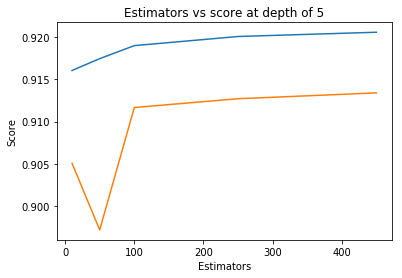

In [29]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

Here we can observe that even after 100 estimators even upto 450, the f1_score is not improving much.

depth =  3 Train Score 0.9029276126163222 test Score 0.8723602353040756
depth =  9 Train Score 0.9584909508029569 test Score 0.9232554704479753
depth =  11 Train Score 0.960793893129771 test Score 0.9246985411923434
depth =  15 Train Score 0.9632354435524845 test Score 0.9260016439395535
depth =  20 Train Score 0.9635841260494818 test Score 0.9261527453332492
depth =  35 Train Score 0.9634494168755899 test Score 0.9259383942097289
depth =  50 Train Score 0.9634494168755899 test Score 0.9259383942097289
depth =  70 Train Score 0.9634494168755899 test Score 0.9259383942097289
depth =  130 Train Score 0.9634494168755899 test Score 0.9259383942097289


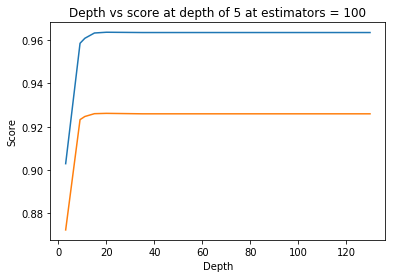

In [41]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 100')
plt.show()

Here after 11 if we increase the max_depth we are not getting any certain improvement in our f1_score.

In [31]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(100,120),
              "max_depth": sp_randint(5,11),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.95655794 0.93790359 0.92247466 0.94873079 0.95756643]


In [32]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=116,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [33]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=116,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)

In [34]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [35]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9582255007845455
Test f1 score 0.9242529534398889


In [36]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


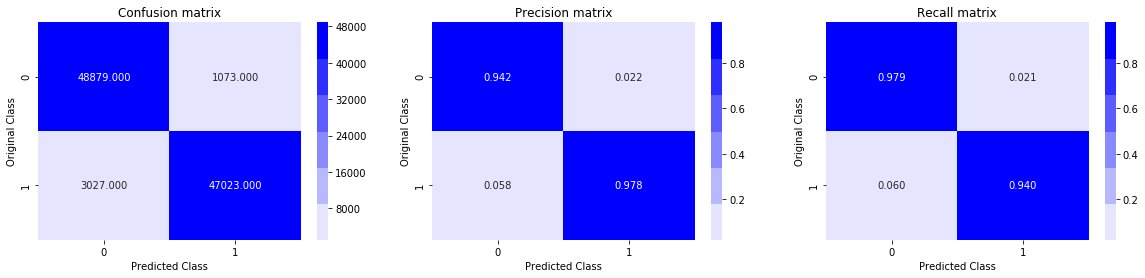

Test confusion_matrix


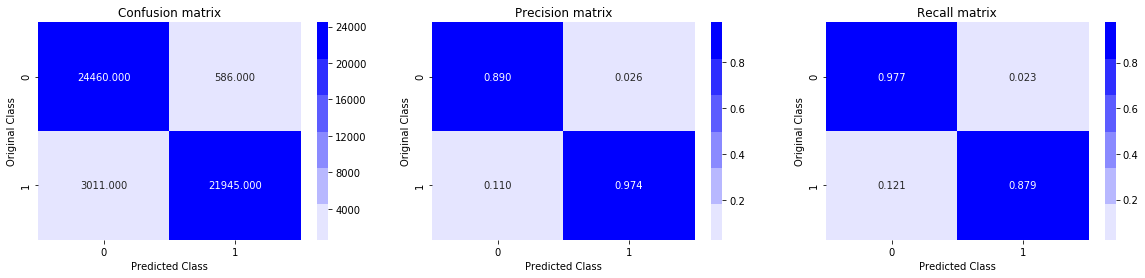

In [37]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

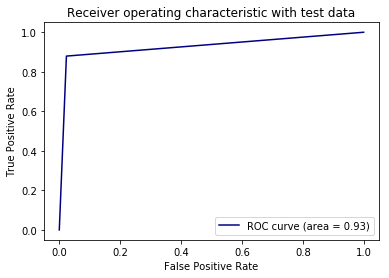

In [38]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

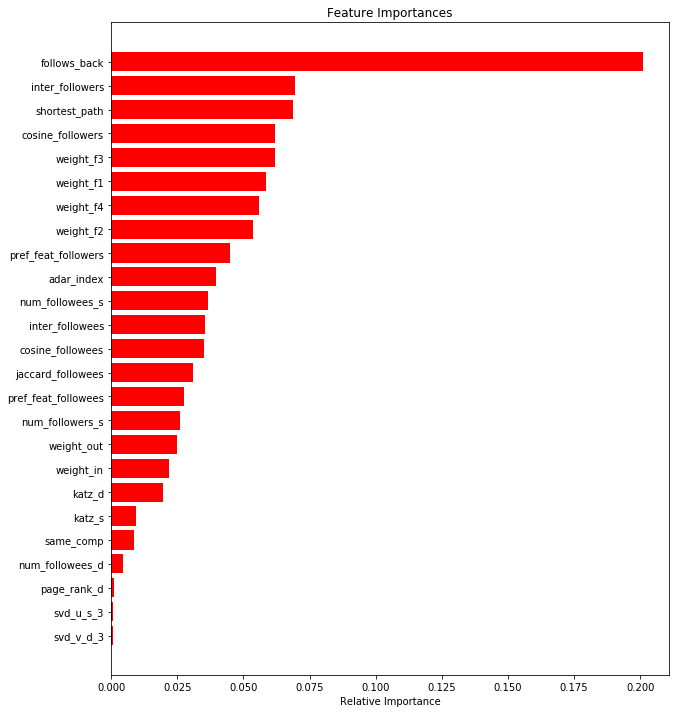

In [30]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

> Applying XGBoost Classifier 

Estimators =  10 Train Score 0.9210492696844526 test Score 0.9162413689582708
Estimators =  20 Train Score 0.9300264229995895 test Score 0.9228646629308881
Estimators =  30 Train Score 0.9625881224685514 test Score 0.9237192937835146
Estimators =  50 Train Score 0.9675354922332259 test Score 0.9231354642313546
Estimators =  100 Train Score 0.9735434729762581 test Score 0.927852099985159
Estimators =  250 Train Score 0.97811089000899 test Score 0.9184677937085384


Text(0.5,1,'Estimators vs score at depth of 3')

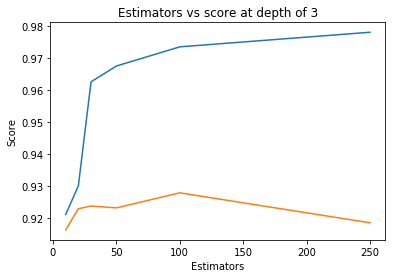

In [40]:
import xgboost as xgb
# with estimator values greater than 50 may be are overfitting
# as the difference between train score and test score is increasing
estimators = [10,20,30,50,100, 250]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=i,n_jobs=-1, random_state=25)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 3')

Here as we increase the number of estimators it seems that overfitting might happen as the differnce between the trian score and test score seems to increase as well.

depth =  3 Train Score 0.9625881224685514 test Score 0.9237192937835146
depth =  9 Train Score 0.977793515099398 test Score 0.9339130801865885
depth =  11 Train Score 0.9828447953795045 test Score 0.9337604585976522
depth =  15 Train Score 0.9948626357086954 test Score 0.9335158471096136
depth =  20 Train Score 0.9989705250322335 test Score 0.9331059314004169
depth =  35 Train Score 0.9995904627770619 test Score 0.9329320903217659
depth =  50 Train Score 0.9996004474988014 test Score 0.9328307925545355
depth =  70 Train Score 0.9996004474988014 test Score 0.9328307925545355


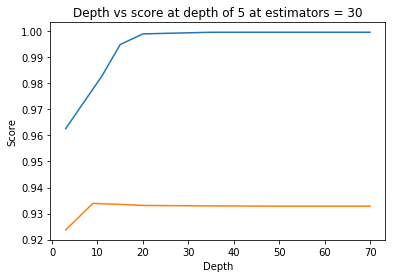

In [43]:
depths = [3,9,11,15,20,35,50,70]
train_scores = []
test_scores = []
for i in depths:
    clf = xgb.XGBClassifier(max_depth=i, n_estimators=30,n_jobs=-1, random_state=25)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 30')
plt.show()

As the depth increases the training score is increasing but the test score is not increasing as much after 9.

In [47]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":(30,40), "max_depth":(3,8)}
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25, return_train_score=True)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])
print('mean train scores',model.cv_results_['mean_train_score'])

mean test scores [0.95794375 0.96301244 0.97390993 0.97443317]
mean train scores [0.95836019 0.96324525 0.97602678 0.97680809]


In [48]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=40,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)


In [49]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=40,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [50]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [51]:
# for n_estimators = 30 we get this results
# Train f1 score 0.9735434729762581
# Test f1 score 0.927852099985159


print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9761367202923934
Test f1 score 0.9319263222450146


In [52]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


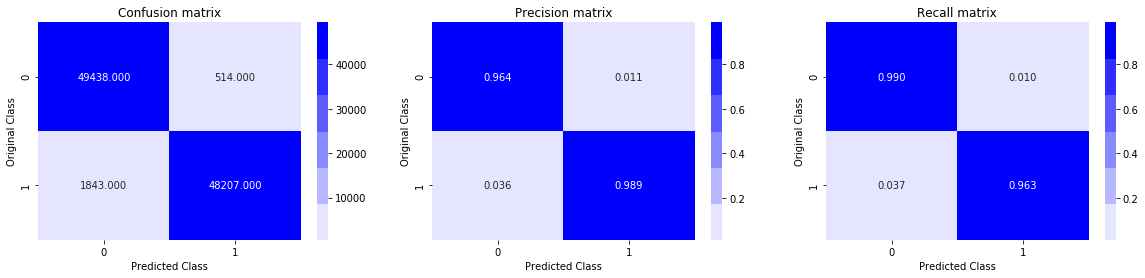

Test confusion_matrix


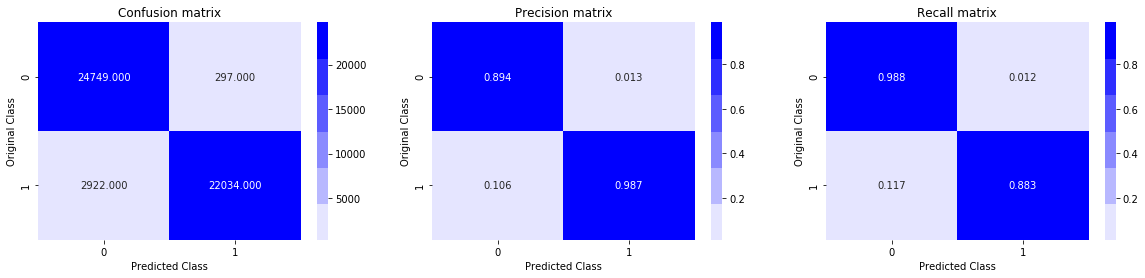

In [53]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

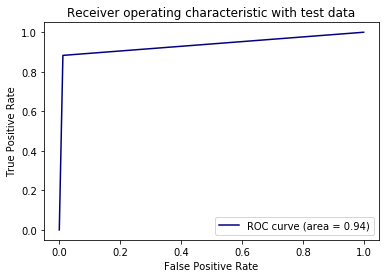

In [54]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

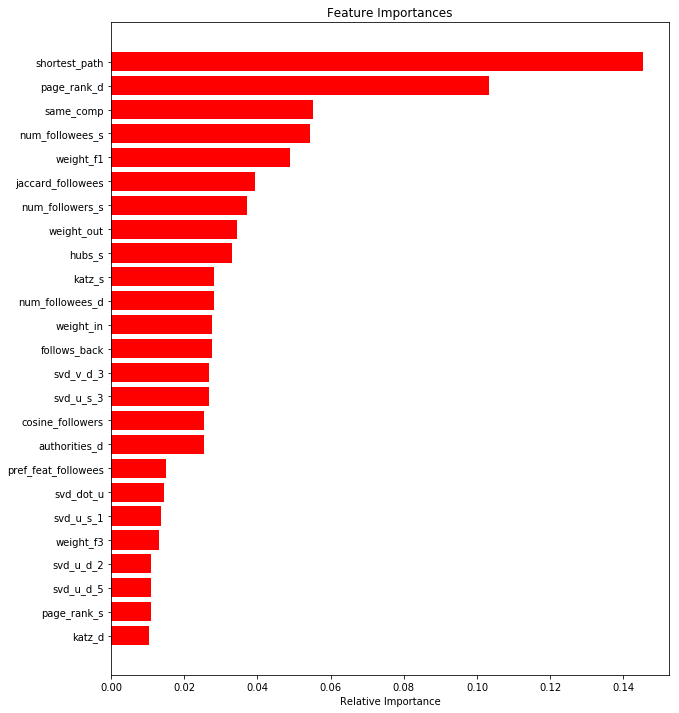

In [55]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [56]:
tab = PrettyTable()
tab.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
tab.add_row(['Random Forest','116','9','0.958','0.924'])
tab.add_row(['XGBOOST','40','8','0.976','0.931'])
print(tab)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     116      |     9     |     0.958      |     0.924     |
|    XGBOOST    |      40      |     8     |     0.976      |     0.931     |
+---------------+--------------+-----------+----------------+---------------+




1) Initially we had only a couple feature in our data-set i.e Source_node and Destinantion_node. 

2) Then we generated class labels so if we have an edge between two nodes then 1 otherwise 0 also as we have nodes which already have edge in between so we intensionally generated some extra nodes which don't have edge in between and assign 0 as class label.

3) Then we have used feature engineering to construct some graph based features like, shortest path, jaccard distance, cosine distance, preferential attachments and many more.

4) After that we started with our normal routine of splitting the data before the modeling.

5) Before modeling we also did some hyper parameter tuning and used RandomSearch cross validation. 

6) Then we used Random Forest classifier and XGBoost classifier here to model our data and used f1_score as our performance metric. 

6) Then we saw how our model is performing using confusion, precision, recall metrices also we plot feature importance to find which features are most useful in the model.